In [1]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import matplotlib.pyplot as plt

# Cargar CSVs
train_df = pd.read_csv('Dataset-SupermarketImages/annotations.csv')
val_df = pd.read_csv('Dataset-SupermarketImages/annotations_val.csv')

base_path = 'Dataset-SupermarketImages'


In [2]:
def load_images_and_labels(df, base_path, image_size=(224, 224)):
    images = []
    labels = []

    for _, row in df.iterrows():
        img_path = os.path.join(base_path, row['image'])
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, image_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img.flatten())

        labels.append(row[1:].values.astype(int))  # todas las columnas desde la 2da

    return np.array(images), np.array(labels)

x_train, y_train = load_images_and_labels(train_df, base_path)
x_val, y_val = load_images_and_labels(val_df, base_path)


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier

# Escalar
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

# Modelo
knn = KNeighborsClassifier(n_neighbors=3)
multi_knn = MultiOutputClassifier(knn)
multi_knn.fit(x_train_scaled, y_train)

# Predicción
y_pred = multi_knn.predict(x_val_scaled)

# Evaluación
from sklearn.metrics import classification_report
etiquetas = train_df.columns[1:]  # nombres de clases
print(classification_report(y_val, y_pred, target_names=etiquetas))


                  precision    recall  f1-score   support

          Banana       1.00      1.00      1.00         6
          Orange       0.83      1.00      0.91         5
 Red-Bell-Pepper       1.00      0.80      0.89         5
  aluminium_form       0.80      0.80      0.80         5
           bread       1.00      1.00      1.00         5
doritos_cocaCola       1.00      0.75      0.86         4
        red_bull       0.83      1.00      0.91         5
     shampoo_H&S       0.00      0.00      0.00         5
             tea       1.00      0.20      0.33         5
 yogurt_toni_mix       0.38      1.00      0.56         5

       micro avg       0.78      0.76      0.77        50
       macro avg       0.79      0.76      0.73        50
    weighted avg       0.79      0.76      0.73        50
     samples avg       0.76      0.76      0.76        50



c:\Users\Karen\miniconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Karen\miniconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


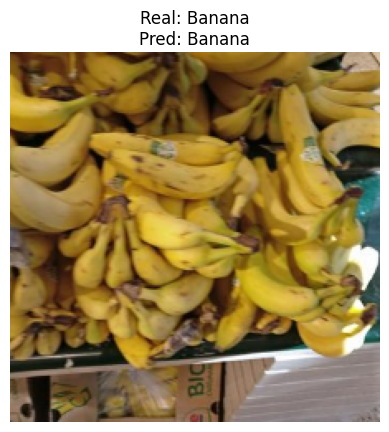

In [7]:
import random

# Elegimos una imagen aleatoria del set de validación
idx = random.randint(0, len(x_val) - 1)
img = x_val[idx].reshape(224, 224, 3)  # la imagen original escalada
real_labels = y_val[idx]
pred_labels = multi_knn.predict([x_val_scaled[idx]])[0]

# Obtener nombres de etiquetas
etiquetas = train_df.columns[1:]
etiquetas_verdaderas = [etiquetas[i] for i, v in enumerate(real_labels) if v == 1]
etiquetas_predichas = [etiquetas[i] for i, v in enumerate(pred_labels) if v == 1]

# Mostrar resultados
plt.imshow(img.astype(np.uint8))
plt.axis('off')
plt.title(f"Real: {', '.join(etiquetas_verdaderas)}\nPred: {', '.join(etiquetas_predichas)}")
plt.show()


    ANÁLISIS: ¿POR QUÉ SHAMPOO ES TAN DIFÍCIL DE PREDECIR?

1. MUESTRAS POR CLASE EN VALIDACIÓN:
   • Banana: 6 muestras
   • Orange: 5 muestras
   • Red-Bell-Pepper: 5 muestras
   • aluminium_form: 5 muestras
   • bread: 5 muestras
   • doritos_cocaCola: 4 muestras
   • red_bull: 5 muestras
   • shampoo_H&S: 5 muestras
   • tea: 5 muestras
   • yogurt_toni_mix: 5 muestras

2. DISTANCIAS EUCLIDIANAS PROMEDIO DESDE SHAMPOO:
   (Menor distancia = mayor similitud)
   • Banana         : promedio=564.04, mínima=486.38
   • Orange         : promedio=622.02, mínima=589.20
   • Red-Bell-Pepper: promedio=654.17, mínima=611.98
   • aluminium_form : promedio=479.29, mínima=380.16
   • bread          : promedio=617.03, mínima=537.40
   • doritos_cocaCola: promedio=653.55, mínima=564.51
   • red_bull       : promedio=461.38, mínima=407.62
   • tea            : promedio=490.39, mínima=384.59
   • yogurt_toni_mix: promedio=475.18, mínima=410.01

   → CLASES MÁS SIMILARES A SHAMPOO (por distancia prom

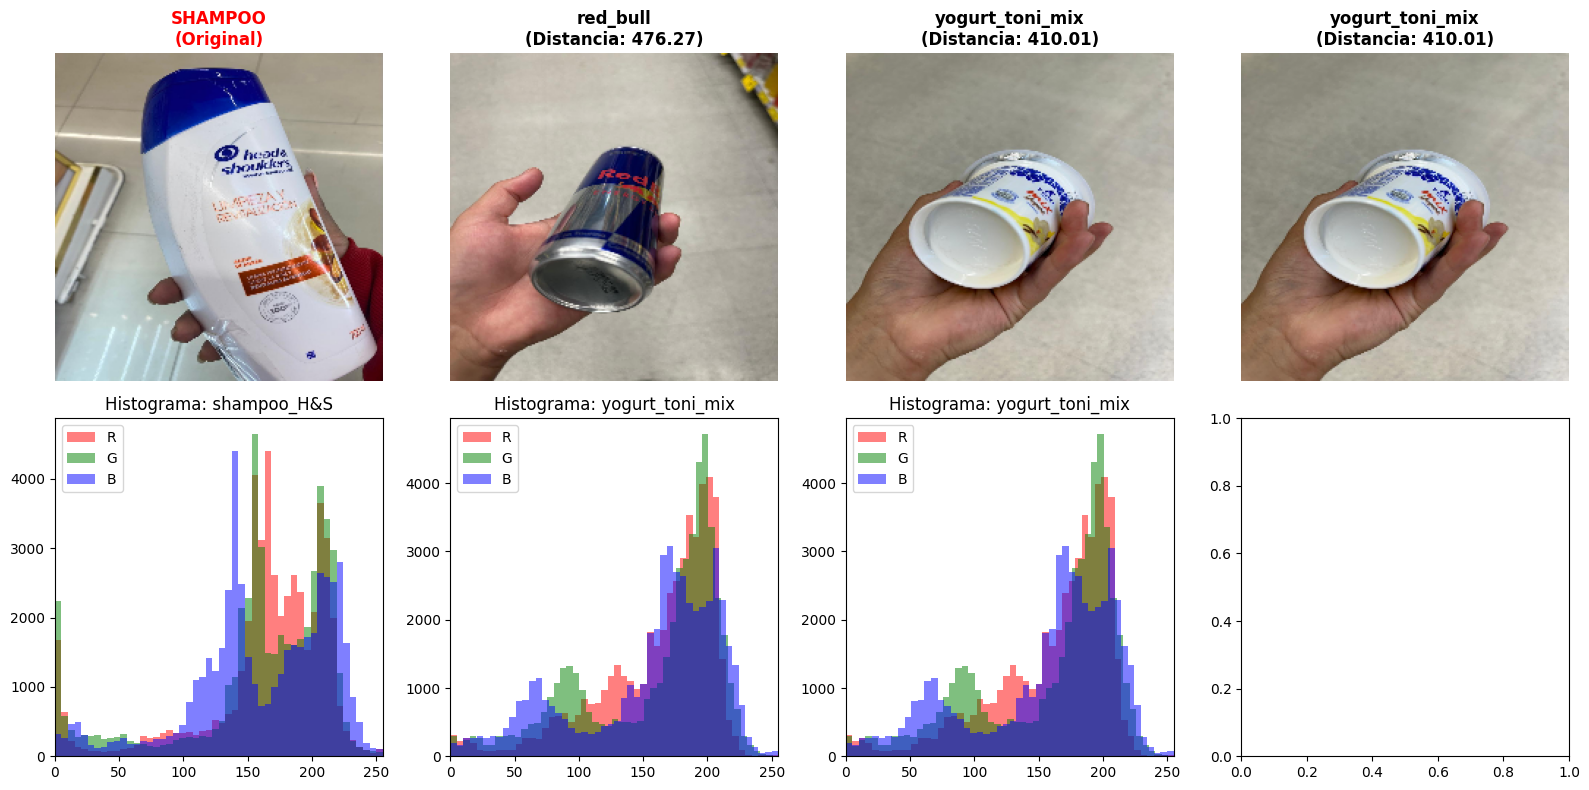


5. ESTADÍSTICAS DE PÍXELES (SHAMPOO vs MÁS SIMILARES):
   Media RGB y Desviación Estándar:
   SHAMPOO:
     RGB promedio: (162.6, 158.3, 160.5)
     RGB std:      (51.9, 59.7, 53.7)
   RED_BULL:
     RGB promedio: (161.7, 151.3, 146.3)
     RGB std:      (52.4, 51.2, 40.1)
   YOGURT_TONI_MIX:
     RGB promedio: (161.6, 157.9, 155.4)
     RGB std:      (45.8, 54.0, 55.9)
   YOGURT_TONI_MIX:
     RGB promedio: (161.6, 157.9, 155.4)
     RGB std:      (45.8, 54.0, 55.9)


In [14]:
# ====== ANÁLISIS DE SIMILITUD DE PÍXELES ======
print("="*60)
print("    ANÁLISIS: ¿POR QUÉ SHAMPOO ES TAN DIFÍCIL DE PREDECIR?")
print("="*60)

# 1. Analizar distancias entre shampoo y otras clases
from sklearn.metrics.pairwise import euclidean_distances

# Obtener índices de cada clase en el set de validación
class_indices = {}
for i, clase in enumerate(etiquetas):
    indices = [j for j, labels in enumerate(y_val) if labels[i] == 1]
    class_indices[clase] = indices

print(f"\n1. MUESTRAS POR CLASE EN VALIDACIÓN:")
for clase, indices in class_indices.items():
    print(f"   • {clase}: {len(indices)} muestras")

# 2. Calcular distancias promedio entre shampoo y otras clases
shampoo_indices = class_indices['shampoo_H&S']
shampoo_samples = x_val_scaled[shampoo_indices]

print(f"\n2. DISTANCIAS EUCLIDIANAS PROMEDIO DESDE SHAMPOO:")
print("   (Menor distancia = mayor similitud)")

distancias_promedio = []
for clase, indices in class_indices.items():
    if clase != 'shampoo_H&S' and len(indices) > 0:
        other_samples = x_val_scaled[indices]
        
        # Calcular todas las distancias entre shampoo y esta clase
        distances = euclidean_distances(shampoo_samples, other_samples)
        avg_distance = distances.mean()
        min_distance = distances.min()
        
        distancias_promedio.append((clase, avg_distance, min_distance))
        print(f"   • {clase:15s}: promedio={avg_distance:.2f}, mínima={min_distance:.2f}")

# Ordenar por similitud (menor distancia = más similar)
distancias_promedio.sort(key=lambda x: x[1])
print(f"\n   → CLASES MÁS SIMILARES A SHAMPOO (por distancia promedio):")
for i, (clase, avg_dist, min_dist) in enumerate(distancias_promedio[:3], 1):
    print(f"   {i}. {clase} (distancia: {avg_dist:.2f})")

# 3. Visualización comparativa
print(f"\n3. COMPARACIÓN VISUAL: SHAMPOO vs CLASES MÁS SIMILARES")

# Tomar una muestra de shampoo
shampoo_idx = shampoo_indices[0]
shampoo_img = x_val[shampoo_idx].reshape(224, 224, 3)

# Encontrar la imagen más similar de cada clase problemática
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# Mostrar shampoo original
axes[0].imshow(shampoo_img.astype(np.uint8))
axes[0].set_title('SHAMPOO\n(Original)', fontweight='bold', color='red')
axes[0].axis('off')

# Mostrar las 3 clases más similares + yogurt (que es donde más se confunde)
clases_comparar = [clase for clase, _, _ in distancias_promedio[:2]] + ['yogurt_toni_mix']
if 'yogurt_toni_mix' not in clases_comparar:
    clases_comparar.append('yogurt_toni_mix')

for i, clase in enumerate(clases_comparar[:3], 1):
    if clase in class_indices and len(class_indices[clase]) > 0:
        # Encontrar la imagen más similar a shampoo en esta clase
        other_indices = class_indices[clase]
        other_samples = x_val_scaled[other_indices]
        
        distances = euclidean_distances([x_val_scaled[shampoo_idx]], other_samples)[0]
        most_similar_idx = other_indices[distances.argmin()]
        
        similar_img = x_val[most_similar_idx].reshape(224, 224, 3)
        axes[i].imshow(similar_img.astype(np.uint8))
        axes[i].set_title(f'{clase}\n(Distancia: {distances.min():.2f})', fontweight='bold')
        axes[i].axis('off')

# 4. Análisis de histogramas de color
print(f"\n4. ANÁLISIS DE DISTRIBUCIÓN DE COLORES:")

for i in range(4, 8):
    if i-4 < len(clases_comparar):
        clase = clases_comparar[i-4] if i > 4 else 'shampoo_H&S'
        
        if clase in class_indices and len(class_indices[clase]) > 0:
            if clase == 'shampoo_H&S':
                img = shampoo_img
            else:
                idx = class_indices[clase][0]
                img = x_val[idx].reshape(224, 224, 3)
            
            # Histograma de intensidades RGB
            axes[i].hist(img[:,:,0].flatten(), bins=50, alpha=0.5, label='R', color='red')
            axes[i].hist(img[:,:,1].flatten(), bins=50, alpha=0.5, label='G', color='green')
            axes[i].hist(img[:,:,2].flatten(), bins=50, alpha=0.5, label='B', color='blue')
            axes[i].set_title(f'Histograma: {clase}')
            axes[i].legend()
            axes[i].set_xlim(0, 255)

plt.tight_layout()
plt.show()

# 5. Análisis estadístico de píxeles
print(f"\n5. ESTADÍSTICAS DE PÍXELES (SHAMPOO vs MÁS SIMILARES):")
print("   Media RGB y Desviación Estándar:")

shampoo_stats = {
    'mean_r': shampoo_img[:,:,0].mean(),
    'mean_g': shampoo_img[:,:,1].mean(),
    'mean_b': shampoo_img[:,:,2].mean(),
    'std_r': shampoo_img[:,:,0].std(),
    'std_g': shampoo_img[:,:,1].std(),
    'std_b': shampoo_img[:,:,2].std()
}

print(f"   SHAMPOO:")
print(f"     RGB promedio: ({shampoo_stats['mean_r']:.1f}, {shampoo_stats['mean_g']:.1f}, {shampoo_stats['mean_b']:.1f})")
print(f"     RGB std:      ({shampoo_stats['std_r']:.1f}, {shampoo_stats['std_g']:.1f}, {shampoo_stats['std_b']:.1f})")

for clase in clases_comparar[:3]:
    if clase in class_indices and len(class_indices[clase]) > 0:
        idx = class_indices[clase][0]
        img = x_val[idx].reshape(224, 224, 3)
        
        print(f"   {clase.upper()}:")
        print(f"     RGB promedio: ({img[:,:,0].mean():.1f}, {img[:,:,1].mean():.1f}, {img[:,:,2].mean():.1f})")
        print(f"     RGB std:      ({img[:,:,0].std():.1f}, {img[:,:,1].std():.1f}, {img[:,:,2].std():.1f})")

print("="*60)

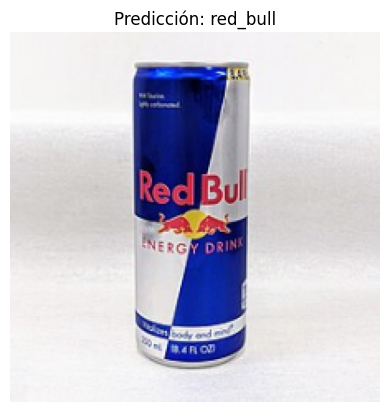

In [10]:
def predecir_imagen(modelo, scaler, ruta_imagen, etiquetas, image_size=(224,224)):
    img = cv2.imread(ruta_imagen)
    img = cv2.resize(img, image_size)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x = img_rgb.flatten().reshape(1, -1)
    x_scaled = scaler.transform(x)

    pred = modelo.predict(x_scaled)[0]
    etiquetas_predichas = [etiquetas[i] for i, v in enumerate(pred) if v == 1]

    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Predicción: {', '.join(etiquetas_predichas)}")
    plt.show()

# Ejemplo de uso:
etiquetas = train_df.columns[1:]
predecir_imagen(multi_knn, scaler, 'rb.jpg', etiquetas)
